In [1]:
from google.colab import drive  
drive._mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pip install tensorflow==2.1.0

In [4]:
pip install h5py==2.10.0

In [5]:
pip install keras==2.3.0

In [6]:
# importing the required package
import numpy as np
import tensorflow as tf
import random as rn
import os, sys
import time
from keras import backend as K
import PIL
from PIL import Image
import PIL.Image
import keras, glob
from keras.preprocessing import image as kImage
from skimage.transform import pyramid_gaussian
from sklearn.utils import compute_class_weight
from keras.utils.data_utils import get_file
from keras.models import Model
from keras.layers import Activation, Input, Dropout, BatchNormalization, SpatialDropout2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras import regularizers
from keras.engine.topology import Layer
from keras.utils import conv_utils
from keras.legacy import interfaces
from keras.engine.base_layer import InputSpec
from keras.models import load_model
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [7]:
# For reproducing the environment
np.random.seed(42)
rn.seed(12345)
tf.random.set_seed(1234)

Training Model *B2*

In [8]:
# Define Data Generator (Inspired by FgSegNet)
def generateData(train_dir, dataset_dir, scene, method_name):
    void_label = -1. # defining label to be assigned to non-RoI
    
    # Given ground-truths, load training frames
    # ground-truths end with '*.png'
    # training frames end with '*.jpg'
    
    # given ground-truths, load inputs  
    Y_list = glob.glob(os.path.join(train_dir, '*.png')) #stores the location of all the 50 files in ground truth.
    X_list= glob.glob(os.path.join(dataset_dir, 'input','*.jpg')) #stores the location of all files in input directory

    #for every file name in Ground Truth (Y) find the corresponding file in Input directory (X)
    X_list_temp = []
    for i in range(len(Y_list)):
        Y_name = os.path.basename(Y_list[i]) 
        Y_name = Y_name.split('.')[0]
        Y_name = Y_name.split('gt')[1]
        for j in range(len(X_list)):
            X_name = os.path.basename(X_list[j])
            X_name = X_name.split('.')[0]
            X_name = X_name.split('in')[1]
            if (Y_name == X_name):
                X_list_temp.append(X_list[j])
                break
            
    X_list = X_list_temp # X corresponding to Ground Truth created
    
    # X must be corresponded to Y
    X_list = sorted(X_list)
    Y_list = sorted(Y_list)

    # load training data
    X = []
    Y = []
    for i in range(len(X_list)):
        x = kImage.load_img(X_list[i]) # load image
        x = x.resize((256, 256))
        x = kImage.img_to_array(x) # convert the loaded image to array
        X.append(x) # create X
        
        x = kImage.load_img(Y_list[i], grayscale = True) # load Y image
        x = x.resize((256, 256))
        x = kImage.img_to_array(x) # convert to array
        shape = x.shape # shape of Y (height x width x 1)
        x /= 255.0 # normalize to fit the range 0 to 1
        x = x.reshape(-1) # flatten to find out pixels corresponding to non-ROI
        idx = np.where(np.logical_and(x>0.19, x<0.8))[0] # find non-ROI
        if (len(idx)>0):
            x[idx] = void_label # assigning -1 to the non-ROI region of image
        x = x.reshape(shape) # reshape the image back to original size
        x = np.floor(x) #floor to the nearest integer. so now we have only 3 values: -1, 0, 1
        Y.append(x) #create list of Y
   
   # Convert X and Y to array     
    X = np.asarray(X)
    Y = np.asarray(Y)
        
    # We do not consider temporal data. soo shuffle 0 to 49 and then apply the shuffled list to X and Y
    idx = list(range(X.shape[0])) 
    np.random.shuffle(idx)
    np.random.shuffle(idx)
    X = X[idx]
    Y = Y[idx]
    
   
    return [X,Y] 

In [9]:
def train(results, scene, mdl_path, vgg_weights_path, method_name, category):
    img_shape = results[0][0].shape # (height, width, channel)
        
    model = initModel_S(reg, img_shape, scene, vgg_weights_path)
    
    chk = keras.callbacks.ModelCheckpoint(mdl_path, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    t0=time.time()
    model.fit(results[0], results[1], validation_split=val_split, epochs=max_epochs, batch_size=batch_size, 
              callbacks=[tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1), chk], verbose=1, shuffle = True) 
    print ("training time:",category, ">", scene,  round(time.time()-t0, 3), "s")
    model.save(mdl_path)
        
    del model, results, chk

In [10]:
def VGG16(x): 
  # Block 1
  x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format='channels_last')(x)
  x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    
  # Block 2
  x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
  #x = Dropout(0.5, name='dr1')(x)
  x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
  # Block 3
  x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
  x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
  x = Dropout(0.5, name='dr1')(x)

        
  return x

In [11]:
def transposedConv(x, reg):
  # block 4
 
  x = Conv2DTranspose(32, (1, 1), activation='relu', padding='same', name='block4_tconv1', 
                                                kernel_regularizer=regularizers.l2(reg))(x)
  x = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same', name='block4_tconv2')(x)
  x = Conv2DTranspose(256, (1, 1), activation='relu', padding='same', name='block4_tconv3')(x)

        
  # block 5
  x = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same', name='block5_tconv1', 
                                                kernel_regularizer=regularizers.l2(reg))(x)
        
  # block 6
  x = Conv2DTranspose(1, (1, 1), padding='same', name='block6_tconv1')(x)
  x = Activation('sigmoid')(x)
        
  return x

In [12]:
def acc(y_true, y_pred):
  void_label = -1.
  y_pred = tf.reshape(y_pred, [-1])
  y_true = tf.reshape(y_true, [-1])
  idx = tf.where(tf.not_equal(y_true, tf.constant(void_label, dtype=tf.float32)))
  y_pred = tf.gather_nd(y_pred, idx) 
  y_true = tf.gather_nd(y_true, idx)
  return K.mean(K.equal(y_true, K.round(y_pred)), axis=-1)

In [13]:
def custom_f1(y_true, y_pred):    
    void_label = -1.
    y_pred = tf.reshape(y_pred, [-1])
    y_true = tf.reshape(y_true, [-1])
    idx = tf.where(tf.not_equal(y_true, tf.constant(void_label, dtype=tf.float32)))
    y_pred = tf.gather_nd(y_pred, idx) 
    y_true = tf.gather_nd(y_true, idx)
    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
#https://towardsdatascience.com/dealing-with-class-imbalanced-image-datasets-1cbd17de76b5
def tversky(y_true, y_pred, smooth=1, alpha=0.25):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

In [15]:
#https://towardsdatascience.com/dealing-with-class-imbalanced-image-datasets-1cbd17de76b5
#def tversky_loss(y_true, y_pred):
#    return 1 - tversky(y_true, y_pred)

In [16]:
#https://towardsdatascience.com/dealing-with-class-imbalanced-image-datasets-1cbd17de76b5
def focal_tversky_loss(y_true, y_pred, gamma=2):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

In [17]:
#Loss function
def loss(y_true, y_pred):
  void_label = -1.
  y_pred = K.reshape(y_pred, [-1])
  y_true = K.reshape(y_true, [-1])
  idx = tf.where(tf.not_equal(y_true, tf.constant(void_label, dtype=tf.float32)))
  y_pred = tf.gather_nd(y_pred, idx) 
  y_true = tf.gather_nd(y_true, idx)
  #return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)
  return focal_tversky_loss(y_true, y_pred)

In [18]:
def Bottleneck_block(x):
 
  x0 = Conv2D(16, (1, 1), padding='same')(x)
  
  x1 = Conv2D(16, (1, 3), padding='same', dilation_rate=4)(x0)
        
  x2 = Conv2D(16, (3, 1), padding='same', dilation_rate=4)(x0)

  x00 = keras.layers.add([x0, x1, x2])
  
  x3 = Conv2D(16, (1, 3), padding='same', dilation_rate=8)(x00)
        
  x4 = Conv2D(16, (3, 1), padding='same', dilation_rate=8)(x00)
        
    
  x = keras.layers.concatenate([x, x3, x4], axis=-1)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = SpatialDropout2D(0.25)(x)
  return x

In [19]:
def build_lrfn(lr_start=0.00001, lr_max=0.00075, lr_min=0.0000001, lr_rampup_epochs=30, lr_sustain_epochs=0, lr_exp_decay=.9):
    
    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

In [20]:
lrfn = build_lrfn()

In [21]:
def initModel_S(reg, img_shape, scene, vgg_weights_path):
  assert len(img_shape)==3
  h, w, d = img_shape
        
  input_1 = Input(shape=(h, w, d), name='input')
  vgg_layer_output = VGG16(input_1)
  model = Model(inputs=input_1, outputs=vgg_layer_output, name='model')
  #model.summary()
  model.load_weights(vgg_weights_path, by_name=True)
        
  unfreeze_layers = ['block3_conv2']
  for layer in model.layers:
    if(layer.name not in unfreeze_layers):
      layer.trainable = False
                
  x = model.output
        
               
  x = Bottleneck_block(x)
  x = transposedConv(x, reg)
        
       
  vision_model = Model(inputs=input_1, outputs=x, name='vision_model')
        
  c_loss = loss
  c_acc = acc
  c_custom_f1 = custom_f1
            
  vision_model.compile(loss=c_loss, optimizer= 'adam', metrics=[c_custom_f1,c_acc])
  #vision_model.summary()
  return vision_model

In [24]:
# dataset for ablative experiment. Ran for 50 epochs for this dataset
ablative_dataset = {
            'baseline':['highway'],
            'cameraJitter':['badminton'],
            'badWeather':['skating'],
            'dynamicBackground':['boats'],
            'intermittentObjectMotion':['abandonedBox'],
            'lowFramerate':['port_0_17fps'],
            'nightVideos':['bridgeEntry'],
            'PTZ':['continuousPan'],
            'shadow':['backdoor'],
            'thermal':['corridor'],
            'turbulence':['turbulence0']
}

In [25]:
# overall dataset for final run. Ran 110 epochs.

dataset = {
            'baseline':['highway', 'pedestrians', 'office', 'PETS2006'],
            'cameraJitter':['badminton', 'traffic', 'boulevard', 'sidewalk'],
            'badWeather':['skating', 'blizzard', 'snowFall', 'wetSnow'],
            'dynamicBackground':['boats', 'canoe', 'fall', 'fountain01', 'fountain02', 'overpass'],
            'intermittentObjectMotion':['abandonedBox', 'parking', 'sofa', 'streetLight', 'tramstop', 'winterDriveway'],
            'lowFramerate':['port_0_17fps', 'tramCrossroad_1fps', 'tunnelExit_0_35fps', 'turnpike_0_5fps'],
            'nightVideos':['bridgeEntry', 'busyBoulvard', 'fluidHighway', 'streetCornerAtNight', 'tramStation', 'winterStreet'],
            'PTZ':['continuousPan', 'intermittentPan', 'twoPositionPTZCam', 'zoomInZoomOut'],
            'shadow':['backdoor', 'bungalows', 'busStation', 'copyMachine', 'cubicle', 'peopleInShade'],
            'thermal':['corridor', 'diningRoom', 'lakeSide', 'library', 'park'],
            'turbulence':['turbulence0', 'turbulence1', 'turbulence2', 'turbulence3']
}


In [26]:
num_frames = 50 # default 50 frames
reg=5e-2 # 5e-4
val_split = 0.2 #Assumed. For num_frames = 50; 40 frames will be used for training and 10 frames will be used for validation
batch_size = 1 #Assumed to be 1

In [29]:
method_name = 'ModelB2ablative'
main_dir = os.path.join('/content/drive/MyDrive/FgSegNet', method_name)
main_mdl_dir = os.path.join(main_dir, 'CDnet', 'models' + str(num_frames))
vgg_weights_path = '/content/drive/MyDrive/FgSegNet/FgSegNet/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [30]:
# abaltive run for ablative_dataset for 50 epochs
max_epochs = 50
for category, scene_list in ablative_dataset.items():
    
    mdl_dir = os.path.join(main_mdl_dir, category)
    if not os.path.exists(mdl_dir):
        os.makedirs(mdl_dir)
        
    for scene in scene_list:
        print ('Training ->>> ' + category + ' / ' + scene)
        
        # training frame path and dataset2014 path
        train_dir = os.path.join('/content/drive/MyDrive/FgSegNet', 'FgSegNet_dataset2014', category, scene + str(num_frames))
        dataset_dir = os.path.join('/content/drive/MyDrive/FgSegNet', 'CDnet2014_dataset', category, scene)
        results = generateData(train_dir, dataset_dir, scene, method_name)
        
        mdl_path = os.path.join(mdl_dir, 'mdl_' + scene + '.h5')
        train(results, scene, mdl_path, vgg_weights_path, method_name, category)
        del results

Training ->>> baseline / highway
Train on 40 samples, validate on 10 samples
Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
40/40 [==============================] - 3s 76ms/step - loss: 8.7035 - custom_f1: 0.1819 - acc: 0.3342 - val_loss: 8.6321 - val_custom_f1: 0.1780 - val_acc: 0.2711
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 3.4666666666666665e-05.
40/40 [==============================] - 1s 19ms/step - loss: 8.3579 - custom_f1: 0.1852 - acc: 0.1984 - val_loss: 8.0963 - val_custom_f1: 0.1757 - val_acc: 0.1112
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 5.933333333333333e-05.
40/40 [==============================] - 1s 19ms/step - loss: 7.6683 - custom_f1: 0.1839 - acc: 0.1078 - val_loss: 7.2509 - val_custom_f1: 0.1837 - val_acc: 0.1553
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 8.4e-05.
40/40 [==============================] - 1s 19ms/step - loss: 6.7227 - custo

In [38]:
# full run for all datasets for 110 epochs
method_name = 'ModelB2Final'
max_epochs = 110
for category, scene_list in dataset.items():
    
    mdl_dir = os.path.join(main_mdl_dir, category)
    if not os.path.exists(mdl_dir):
        os.makedirs(mdl_dir)
        
    for scene in scene_list:
        print ('Training ->>> ' + category + ' / ' + scene)
        
        # training frame path and dataset2014 path
        train_dir = os.path.join('/content/drive/MyDrive/FgSegNet', 'FgSegNet_dataset2014', category, scene + str(num_frames))
        dataset_dir = os.path.join('/content/drive/MyDrive/FgSegNet', 'CDnet2014_dataset', category, scene)
        results = generateData(train_dir, dataset_dir, scene, method_name)
        
        mdl_path = os.path.join(mdl_dir, 'mdl_' + scene + '.h5')
        train(results, scene, mdl_path, vgg_weights_path, method_name, category)
        del results

Streaming output truncated to the last 5000 lines.
Epoch 00079: LearningRateScheduler reducing learning rate to 4.871377812307849e-06.
40/40 [==============================] - 1s 22ms/step - loss: 0.0040 - custom_f1: 0.9604 - acc: 0.9949 - val_loss: 0.0051 - val_custom_f1: 0.9533 - val_acc: 0.9935
Epoch 80/110

Epoch 00080: LearningRateScheduler reducing learning rate to 4.394240031077064e-06.
40/40 [==============================] - 1s 21ms/step - loss: 0.0040 - custom_f1: 0.9632 - acc: 0.9951 - val_loss: 0.0050 - val_custom_f1: 0.9525 - val_acc: 0.9934
Epoch 81/110

Epoch 00081: LearningRateScheduler reducing learning rate to 3.9648160279693576e-06.
40/40 [==============================] - 1s 21ms/step - loss: 0.0040 - custom_f1: 0.9616 - acc: 0.9950 - val_loss: 0.0050 - val_custom_f1: 0.9531 - val_acc: 0.9935
Epoch 82/110

Epoch 00082: LearningRateScheduler reducing learning rate to 3.5783344251724224e-06.
40/40 [==============================] - 1s 22ms/step - loss: 0.0039 - custom

Testing Model *B2*

In [39]:
# Define Test Data Generator (Inspired by FgSegNet)
def generateTestData(test_dataset_dir, scene, method_name):
    void_label = -1. # defining label to be assigned to non-RoI
    
    # Given ground-truths, load training frames
    # ground-truths end with '*.png'
    # input frames end with '*.jpg'
    
    # prepare a list of Y and X for testing   
    Y_list = glob.glob(os.path.join(test_dataset_dir,'gt', '*.png')) #stores the location of all the 50 files in ground truth.
    X_list= glob.glob(os.path.join(test_dataset_dir, 'input','*.jpg')) #stores the location of all files in input directory

    #keep X for which there is a corresponding Y available
    X_list_temp = []
    for i in range(len(Y_list)):
        Y_name = os.path.basename(Y_list[i]) 
        Y_name = Y_name.split('.')[0]
        Y_name = Y_name.split('gt')[1]
        for j in range(len(X_list)):
            X_name = os.path.basename(X_list[j])
            X_name = X_name.split('.')[0]
            X_name = X_name.split('in')[1]
            if (Y_name == X_name):
                X_list_temp.append(X_list[j])
                break
            
    X_list = X_list_temp # list of X for which there is a corresponding Y available
    
    # X must be corresponded to Y
    X_list = sorted(X_list)
    Y_list = sorted(Y_list)

    # load testing data
    X = []
    Y = []
    for i in range(len(X_list)):
        x = kImage.load_img(X_list[i]) # load image
        x = x.resize((256, 256))
        x = kImage.img_to_array(x) # convert the loaded image to array
        X.append(x) # create X
        
        x = kImage.load_img(Y_list[i], grayscale = True) # load Y image
        x = x.resize((256, 256))
        x = kImage.img_to_array(x) # convert to array
        shape = x.shape # shape of Y (height x width x 1)
        x /= 255.0 # normalize to fit the range 0 to 1
        x = x.reshape(-1) # flatten to find out pixels corresponding to non-ROI
        idx = np.where(np.logical_and(x>0.19, x<0.8))[0] # find non-ROI
        if (len(idx)>0):
            x[idx] = void_label # assigning -1 to the non-ROI region of image
        x = x.reshape(shape) # reshape the image back to original size
        x = np.floor(x) #floor to the nearest integer. so now we have only 3 values: -1, 0, 1
        Y.append(x) #create list of Y
   
   # Convert X and Y to array     
    X = np.asarray(X)
    Y = np.asarray(Y)
        
    # We do not consider temporal data. soo shuffle 0 to 49 and then apply the shuffled list to X and Y
    idx = list(range(X.shape[0])) 
    np.random.shuffle(idx)
    np.random.shuffle(idx)
    X = X[idx]
    Y = Y[idx]
    
   
    return [X,Y] 

In [40]:
# dataset for testing
# model B2 doesn't produce satisfactory results in 'lowFramerate':['port_0_17fps'] & 'PTZ':['continuousPan']. These categories are not used for testing.
test_dataset = {
            'baseline':['highway'],
            'cameraJitter':['badminton'],
            'badWeather':['skating'],
            'dynamicBackground':['boats'],
            'intermittentObjectMotion':['abandonedBox'],
            #'lowFramerate':['port_0_17fps'],
            'nightVideos':['bridgeEntry'],
            #'PTZ':['continuousPan'],
            'shadow':['backdoor'],
            'thermal':['corridor'],
            'turbulence':['turbulence0']
}

In [41]:
main_mdl_dir = os.path.join('/content/drive/MyDrive/FgSegNet/ModelB2Final/CDnet/models50')
method_name = 'ModelB2Final'

Testing ->>> baseline / highway
(5, 256, 256, 3) (5, 256, 256, 1)
5/5 [==============================] - 0s 37ms/step
(5, 256, 256, 1)
(5, 256, 256)
F Score for baseline highway is tf.Tensor(0.9637915, shape=(), dtype=float32)


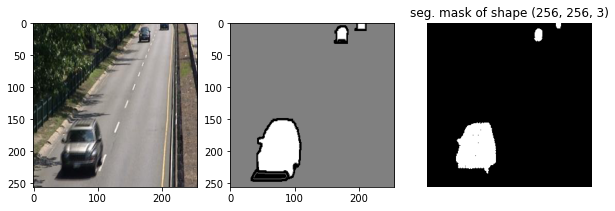

Testing ->>> cameraJitter / badminton
(5, 256, 256, 3) (5, 256, 256, 1)
5/5 [==============================] - 0s 34ms/step
(5, 256, 256, 1)
(5, 256, 256)
F Score for cameraJitter badminton is tf.Tensor(0.8652956, shape=(), dtype=float32)


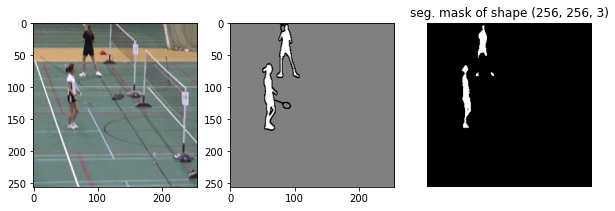

Testing ->>> badWeather / skating
(5, 256, 256, 3) (5, 256, 256, 1)
5/5 [==============================] - 0s 34ms/step
(5, 256, 256, 1)
(5, 256, 256)
F Score for badWeather skating is tf.Tensor(0.95457673, shape=(), dtype=float32)


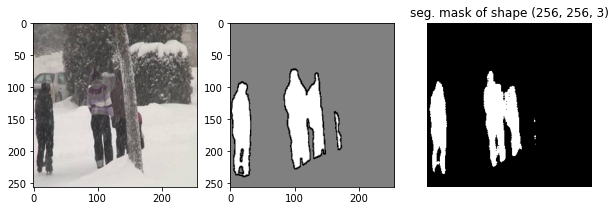

Testing ->>> dynamicBackground / boats
(5, 256, 256, 3) (5, 256, 256, 1)
5/5 [==============================] - 0s 36ms/step
(5, 256, 256, 1)
(5, 256, 256)
F Score for dynamicBackground boats is tf.Tensor(0.9558019, shape=(), dtype=float32)


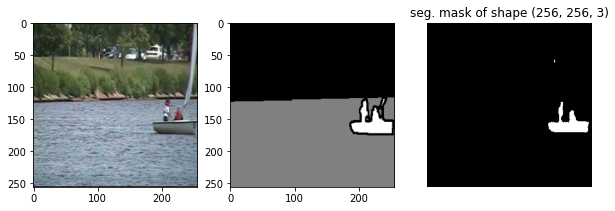

Testing ->>> intermittentObjectMotion / abandonedBox
(5, 256, 256, 3) (5, 256, 256, 1)
5/5 [==============================] - 0s 32ms/step
(5, 256, 256, 1)
(5, 256, 256)
F Score for intermittentObjectMotion abandonedBox is tf.Tensor(0.8707182, shape=(), dtype=float32)


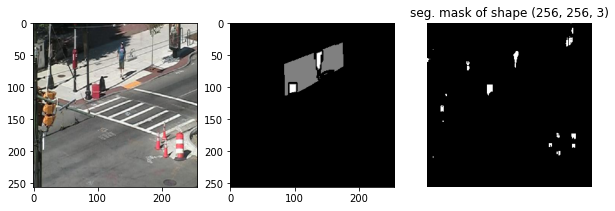

Testing ->>> nightVideos / bridgeEntry
(5, 256, 256, 3) (5, 256, 256, 1)
5/5 [==============================] - 0s 34ms/step
(5, 256, 256, 1)
(5, 256, 256)
F Score for nightVideos bridgeEntry is tf.Tensor(0.8799231, shape=(), dtype=float32)


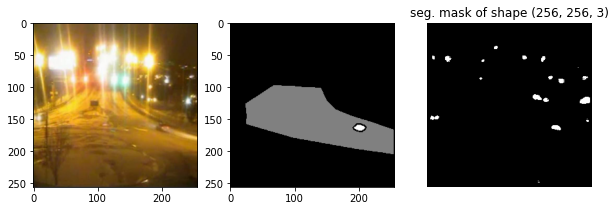

Testing ->>> shadow / backdoor
(5, 256, 256, 3) (5, 256, 256, 1)
5/5 [==============================] - 0s 33ms/step
(5, 256, 256, 1)
(5, 256, 256)
F Score for shadow backdoor is tf.Tensor(0.9381757, shape=(), dtype=float32)


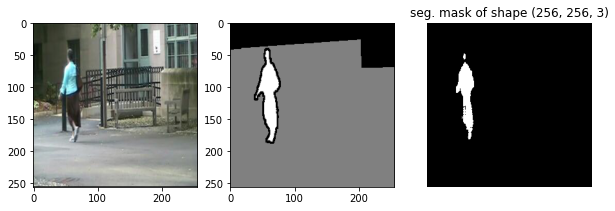

Testing ->>> thermal / corridor
(5, 256, 256, 3) (5, 256, 256, 1)
5/5 [==============================] - 0s 33ms/step
(5, 256, 256, 1)
(5, 256, 256)
F Score for thermal corridor is tf.Tensor(0.93682295, shape=(), dtype=float32)


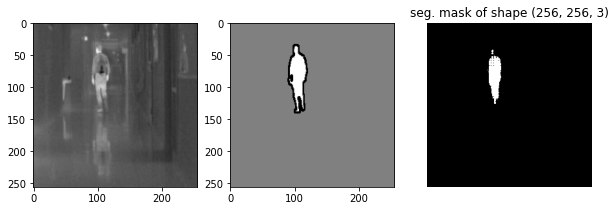

Testing ->>> turbulence / turbulence0
(5, 256, 256, 3) (5, 256, 256, 1)
5/5 [==============================] - 0s 34ms/step
(5, 256, 256, 1)
(5, 256, 256)
F Score for turbulence turbulence0 is tf.Tensor(0.90105474, shape=(), dtype=float32)


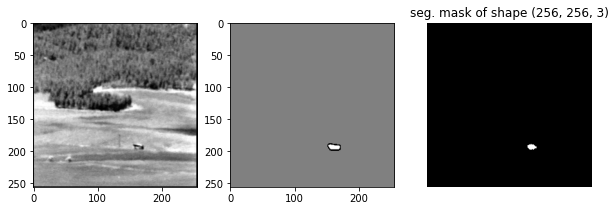

In [42]:
for category, scene_list in test_dataset.items():
    
    mdl_dir = os.path.join(main_mdl_dir, category)
    #if not os.path.exists(mdl_dir):
        #os.makedirs(mdl_dir)
        
    for scene in scene_list:
        print ('Testing ->>> ' + category + ' / ' + scene)
        
        # test data set path
        
        test_dataset_dir = os.path.join('/content/drive/MyDrive/FgSegNet', 'sample_test_frames', category, scene)
        results = generateTestData(test_dataset_dir, scene, method_name)

        print (results[0].shape, results[1].shape)
        
        mdl_path = os.path.join(mdl_dir, 'mdl_' + scene + '.h5')
        
        model = load_model(mdl_path, compile=False) # load the saved model that is trained with 50 frames
        
        y_pred = model.predict(results[0], batch_size=1, verbose=1)
        print(y_pred.shape) # (5, 256,256,1)
        y_pred = y_pred.reshape([y_pred.shape[0], y_pred.shape[1], y_pred.shape[2]])
        print(y_pred.shape) # (5, 256,256)

        results[1] = results[1].reshape([results[1].shape[0], results[1].shape[1], results[1].shape[2]])
        
        #print model F-Score

        #print("F Score for", category, scene, "is", custom_f1(results[1],y_pred))
        print("F Score for", category, scene, "is", custom_f1(results[1],y_pred))
        
        # predicting foreground masks
        idx = 2 # Foreground mask for fifth image out of the 5 images for testing
        x = results[0][idx] # the input image for testing

        gt = results[1][idx] # the ground truth correspodning to inpput image

        y_pred = y_pred[idx] # the predicted image
        
        threshold = 0.8 # a threshold value below which the mask will be zero else 1
        y_pred[y_pred<threshold] = 0.
        y_pred[y_pred>=threshold] = 1.

         
        plt.rcParams['figure.figsize'] = (10.0, 5.0)
        
        plt.subplot(1, 3, 1)
        
        plt.imshow(x.astype('uint8'))
        
        plt.subplot(1, 3, 2)
        
        plt.rcParams['image.cmap'] = 'gray'

        plt.imshow(gt)

        plt.subplot(1, 3, 3)
        
        plt.rcParams['image.cmap'] = 'gray'

        plt.imshow(y_pred)

        plt.title('seg. mask of shape ' + str(x.shape))
        plt.axis('off')
        plt.show()
        del results

In [ ]:
# Define Data Generator for inference time (Inspired by FgSegNet)
def generateTestDataforinferencetime(test_dataset_dir, scene, method_name):
    void_label = -1. # defining label to be assigned to non-RoI
    
    # Given ground-truths, load training frames
    # ground-truths end with '*.png'
    # input frames end with '*.jpg'
    
    # prepare a list of Y and X for testing   
    Y_list = glob.glob(os.path.join(test_dataset_dir,'groundtruth', '*.png')) #stores the location of all the 50 files in ground truth.
    X_list= glob.glob(os.path.join(test_dataset_dir, 'input','*.jpg')) #stores the location of all files in input directory

    #keep X for which there is a corresponding Y available
    X_list_temp = []
    for i in range(len(Y_list)):
        Y_name = os.path.basename(Y_list[i]) 
        Y_name = Y_name.split('.')[0]
        Y_name = Y_name.split('gt')[1]
        for j in range(len(X_list)):
            X_name = os.path.basename(X_list[j])
            X_name = X_name.split('.')[0]
            X_name = X_name.split('in')[1]
            if (Y_name == X_name):
                X_list_temp.append(X_list[j])
                break
            
    X_list = X_list_temp # list of X for which there is a corresponding Y available
    
    # X must be corresponded to Y
    X_list = sorted(X_list)
    Y_list = sorted(Y_list)

    # load testing data
    X = []
    Y = []
    for i in range(len(X_list)):
        x = kImage.load_img(X_list[i]) # load image
        x = x.resize((256, 256))
        x = kImage.img_to_array(x) # convert the loaded image to array
        X.append(x) # create X
        
        x = kImage.load_img(Y_list[i], grayscale = True) # load Y image
        x = x.resize((256, 256))
        x = kImage.img_to_array(x) # convert to array
        shape = x.shape # shape of Y (height x width x 1)
        x /= 255.0 # normalize to fit the range 0 to 1
        x = x.reshape(-1) # flatten to find out pixels corresponding to non-ROI
        idx = np.where(np.logical_and(x>0.19, x<0.8))[0] # find non-ROI
        if (len(idx)>0):
            x[idx] = void_label # assigning -1 to the non-ROI region of image
        x = x.reshape(shape) # reshape the image back to original size
        x = np.floor(x) #floor to the nearest integer. so now we have only 3 values: -1, 0, 1
        Y.append(x) #create list of Y
   
   # Convert X and Y to array     
    X = np.asarray(X)
    Y = np.asarray(Y)
        
    # We do not consider temporal data. soo shuffle 0 to 49 and then apply the shuffled list to X and Y
    idx = list(range(X.shape[0])) 
    np.random.shuffle(idx)
    np.random.shuffle(idx)
    X = X[idx]
    Y = Y[idx]
    
   
    return [X,Y] 

Testing ->>> baseline / highway
(1700, 256, 256, 3) (1700, 256, 256, 1)
1700/1700 [==============================] - 12s 7ms/step
inference time: baseline > highway 12.362 s
(1700, 256, 256, 1)
(1700, 256, 256)
F Score for baseline highway is tf.Tensor(0.95592225, shape=(), dtype=float32)


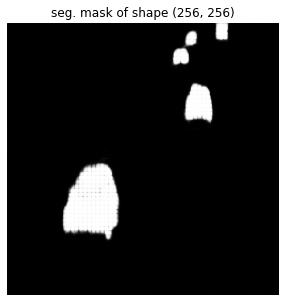

In [43]:
#measuring inference time by running the model for all the images of the category - baseline and scene - highway 



 
mdl_dir = os.path.join(main_mdl_dir, 'baseline')
            
    
print ('Testing ->>> ' + 'baseline' + ' / ' + 'highway')
        
# test data set path
        
test_dataset_dir = '/content/drive/MyDrive/FgSegNet/CDnet2014_dataset/baseline/highway' # path for all the images of baseline highway category

test_dataset = generateTestDataforinferencetime(test_dataset_dir, 'highway', method_name)

print (test_dataset[0].shape, test_dataset[1].shape)
        
mdl_path = os.path.join(mdl_dir, 'mdl_' + 'highway' + '.h5')
        
model = load_model(mdl_path, compile=False) # load the saved model that is trained with 50 frames

t0=time.time()        

y_pred = model.predict(test_dataset[0], batch_size=1, verbose=1)   

print ("inference time:",'baseline', ">", 'highway',  round(time.time()-t0, 3), "s")


print(y_pred.shape) # (5, 256,256,1)
        

        
y_pred = y_pred.reshape([y_pred.shape[0], y_pred.shape[1], y_pred.shape[2]])

        
print(y_pred.shape) # (5, 256,256)

test_dataset[1] = test_dataset[1].reshape([test_dataset[1].shape[0], test_dataset[1].shape[1], test_dataset[1].shape[2]])
        
#print model F-Score

#print("F Score for", category, scene, "is", custom_f1(results[1],y_pred))
print("F Score for", 'baseline', 'highway', "is", custom_f1(test_dataset[1],y_pred))
        
# predicting foreground masks
idx = 2
x = y_pred[idx]

plt.subplot(1, 1, 1)
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams['image.cmap'] = 'gray'

plt.imshow(x)

plt.title('seg. mask of shape ' + str(x.shape))
plt.axis('off')
plt.show()
del test_dataset